In [41]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import imageio

In [42]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [43]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [44]:
# Create directory for saving results
if not os.path.exists('results'):
    os.makedirs('results')
if not os.path.exists('results/reconstructions'):
    os.makedirs('results/reconstructions')
if not os.path.exists('results/samples'):
    os.makedirs('results/samples')

In [45]:
# Data Loading and Transformation
kwargs = {'num_workers': 1, 'pin_memory': True} 

In [46]:
# Hyperparameters
batch_size = 128
latent_size = 256
epochs = 20
num_classes = 10

In [47]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./MNIST', train=True, download=True,
                   transform=transform),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./MNIST', train=False, transform=transform),
    batch_size=batch_size, shuffle=False, **kwargs)

In [48]:
# Visualize some training examples
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

In [49]:
# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

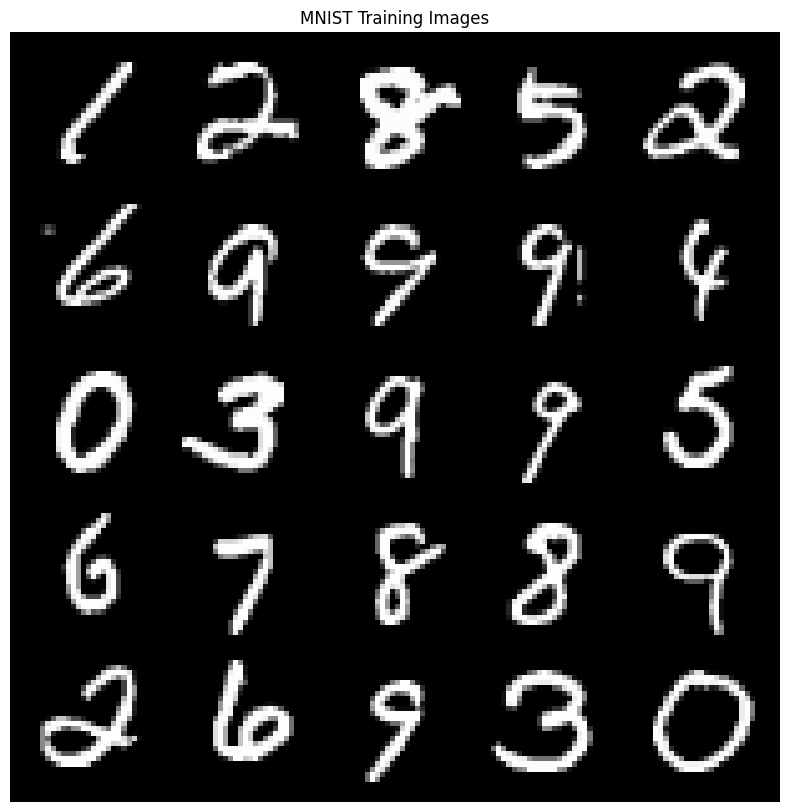

In [50]:
# Create grid of images
img_grid = make_grid(images[:25], nrow=5, padding=2)
plt.figure(figsize=(10, 10))
imshow(img_grid)
plt.title('MNIST Training Images')
plt.savefig('results/training_samples.png')
plt.show()

In [51]:
# Utility Functions
def one_hot(labels, class_size):
    """Convert class labels to one-hot vectors"""
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)

In [52]:
# Model Definition
class CVAE(nn.Module):
    """Conditional Variational Autoencoder"""
    def __init__(self, feature_size, latent_size, class_size):
        super(CVAE, self).__init__()
        self.feature_size = feature_size
        self.class_size = class_size
        self.latent_size = latent_size

        # Encoder Network
        self.encoder = nn.Sequential(
            nn.Linear(feature_size + class_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
        )
        
        # Latent space parameters
        self.fc_mu = nn.Linear(256, latent_size)
        self.fc_logvar = nn.Linear(256, latent_size)
        
        # Decoder Network
        self.decoder = nn.Sequential(
            nn.Linear(latent_size + class_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, feature_size),
            nn.Sigmoid()
        )

    def encode(self, x, c):
        """Encode input into latent parameters (mu and logvar)"""
        inputs = torch.cat([x, c], dim=1)
        h = self.encoder(inputs)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        """Decode latent vector into reconstructed output"""
        inputs = torch.cat([z, c], dim=1)
        return self.decoder(inputs)

    def forward(self, x, c):
        """Full forward pass"""
        mu, logvar = self.encode(x.view(-1, self.feature_size), c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar, z

In [53]:
# Create model
model = CVAE(28 * 28, latent_size, num_classes).to(device)

In [54]:
# Loss Function
def loss_function(recon_x, x, mu, logvar):
    """Calculate loss = reconstruction loss + KL divergence"""
    # Reconstruction loss (binary cross entropy)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    # KL divergence loss (KL(N(μ, σ) || N(0, I))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD

In [55]:
# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [56]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

In [57]:
# Training Function
def train(epoch, history):
    model.train()
    train_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}')
    
    for batch_idx, (data, labels) in enumerate(progress_bar):
        data, labels = data.to(device), labels.to(device)
        c = one_hot(labels, num_classes)
        
        # Forward pass
        recon_batch, mu, logvar, _ = model(data, c)
        
        # Compute loss
        loss = loss_function(recon_batch, data, mu, logvar)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Record loss
        train_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({'Loss': f"{loss.item()/len(data):.4f}"})
    
    # Calculate average epoch loss
    avg_loss = train_loss / len(train_loader.dataset)
    history['train_loss'].append(avg_loss)
    
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')
    return avg_loss

In [58]:
# Testing Function
def test(epoch, history):
    model.eval()
    test_loss = 0
    reconstructions = []
    originals = []
    latent_vectors = []
    test_labels = []
    
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            c = one_hot(labels, num_classes)
            
            # Forward pass
            recon_batch, mu, logvar, z = model(data, c)
            
            # Compute loss
            loss = loss_function(recon_batch, data, mu, logvar)
            test_loss += loss.item()
            
            # Collect data for visualization
            reconstructions.append(recon_batch.cpu())
            originals.append(data.cpu())
            latent_vectors.append(z.cpu())
            test_labels.append(labels.cpu())
    
    # Save reconstructions
    reconstructions = torch.cat(reconstructions, dim=0)
    originals = torch.cat(originals, dim=0)
    
    # Create reconstruction comparison grid
    indices = np.random.choice(len(originals), 10, replace=False)
    comparison = torch.cat([originals[indices], 
                            reconstructions.view(-1, 1, 28, 28)[indices]])
    save_image(comparison.cpu(),
               f'results/reconstructions/reconstruction_{epoch:02d}.png',
               nrow=10, padding=2)
    
    # Visualize reconstructions
    plt.figure(figsize=(10, 5))
    imshow(make_grid(comparison, nrow=10, padding=2))
    plt.title(f'Epoch {epoch} Reconstructions')
    plt.savefig(f'results/reconstructions/reconstruction_grid_{epoch:02d}.png')
    plt.show()
    
    # Calculate average test loss
    avg_loss = test_loss / len(test_loader.dataset)
    history['test_loss'].append(avg_loss)
    print(f'====> Test set loss: {avg_loss:.4f}')
    return avg_loss

In [59]:
# Generate and Save Samples
def save_samples(epoch, latent=None):
    """Generate and save sample images conditioned on class labels"""
    model.eval()
    with torch.no_grad():
        # Create one-hot vectors for each digit class
        c = torch.eye(num_classes, num_classes).to(device)
        
        # Create latent vectors
        if latent is None:
            latent = torch.randn(num_classes, latent_size).to(device)
        
        # Generate samples
        samples = model.decode(latent, c)
        
        # Save samples
        save_image(samples.view(num_classes, 1, 28, 28).cpu(),
                   f'results/samples/sample_{epoch:02d}.png',
                   nrow=num_classes, padding=2)
        
        # Visualize samples
        plt.figure(figsize=(10, 2))
        imshow(make_grid(samples.view(num_classes, 1, 28, 28).cpu(), 
                         nrow=num_classes, padding=2))
        plt.title(f'Epoch {epoch} Generated Samples')
        plt.savefig(f'results/samples/sample_grid_{epoch:02d}.png')
        plt.show()


Starting training...


Epoch 1: 100%|██████████| 469/469 [00:05<00:00, 90.97it/s, Loss=146.9103] 


====> Epoch: 1 Average loss: 175.7306


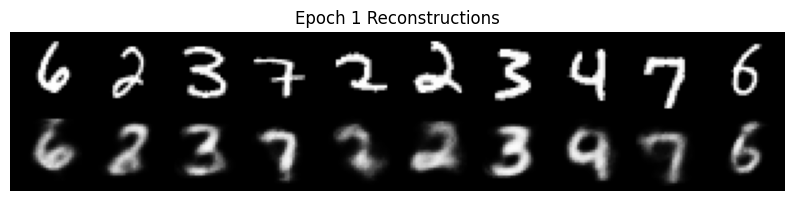

====> Test set loss: 144.0346


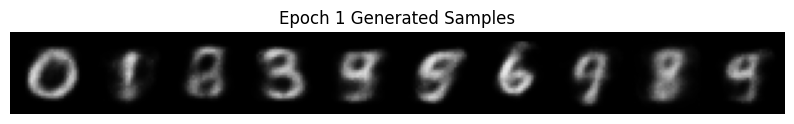

Epoch 2: 100%|██████████| 469/469 [00:04<00:00, 99.07it/s, Loss=129.3347] 


====> Epoch: 2 Average loss: 133.1790


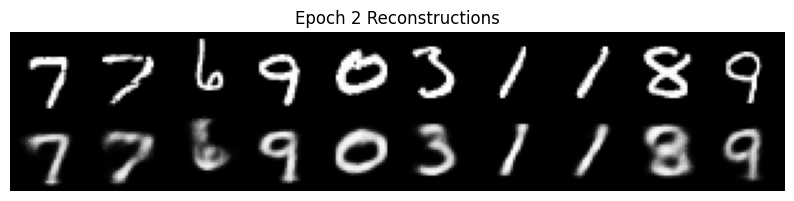

====> Test set loss: 123.2039


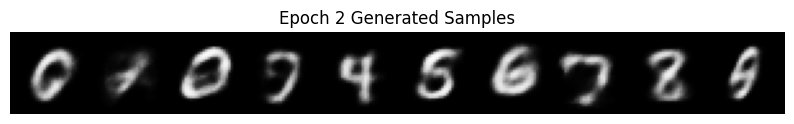

Epoch 3: 100%|██████████| 469/469 [00:05<00:00, 92.52it/s, Loss=119.2049] 


====> Epoch: 3 Average loss: 118.1456


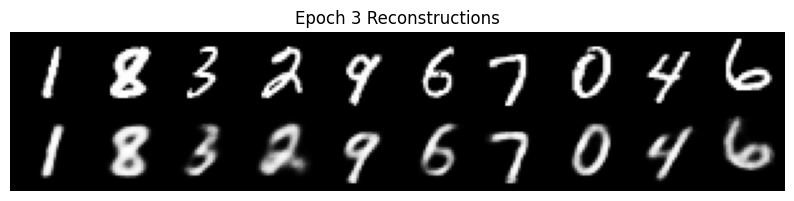

====> Test set loss: 112.9079


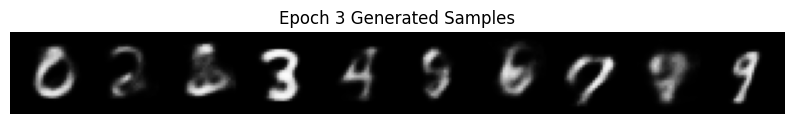

Epoch 4: 100%|██████████| 469/469 [00:05<00:00, 90.30it/s, Loss=106.9617] 


====> Epoch: 4 Average loss: 111.7154


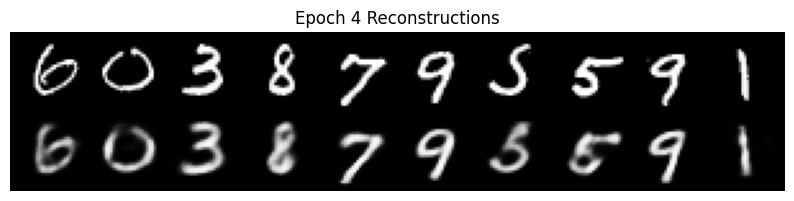

====> Test set loss: 109.0137


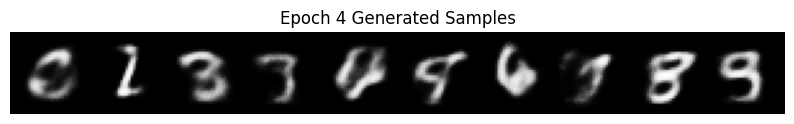

Epoch 5: 100%|██████████| 469/469 [00:05<00:00, 91.13it/s, Loss=106.1006] 


====> Epoch: 5 Average loss: 108.3526


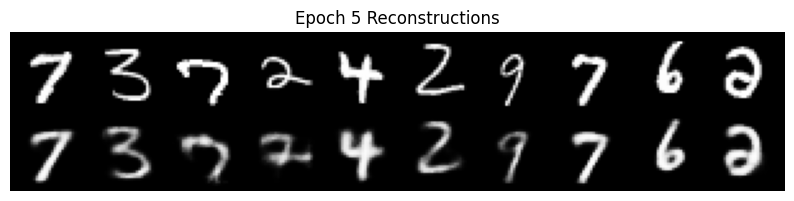

====> Test set loss: 106.1606


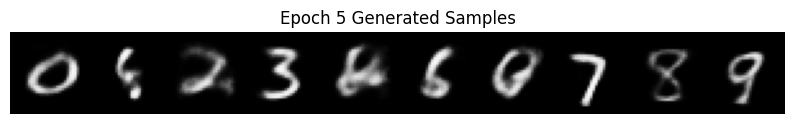

Epoch 6: 100%|██████████| 469/469 [00:05<00:00, 92.23it/s, Loss=103.9276] 


====> Epoch: 6 Average loss: 106.1137


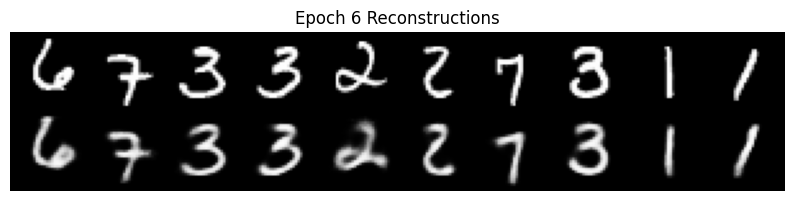

====> Test set loss: 104.4288


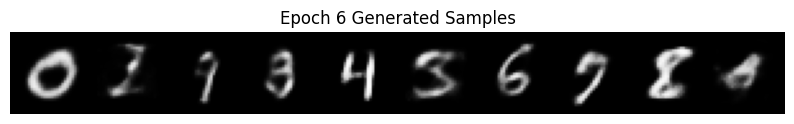

Epoch 7: 100%|██████████| 469/469 [00:04<00:00, 101.61it/s, Loss=106.1364]


====> Epoch: 7 Average loss: 104.2654


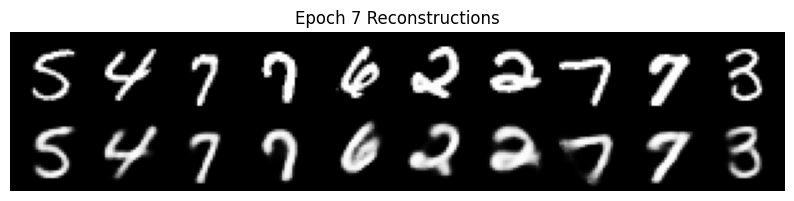

====> Test set loss: 103.1912


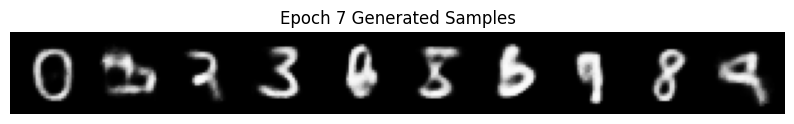

Epoch 8: 100%|██████████| 469/469 [00:05<00:00, 92.07it/s, Loss=106.3034] 


====> Epoch: 8 Average loss: 103.0761


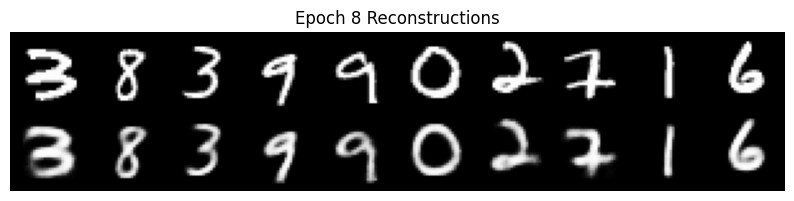

====> Test set loss: 102.1407


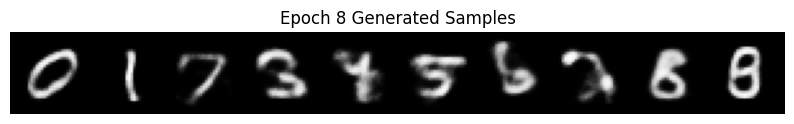

Epoch 9: 100%|██████████| 469/469 [00:04<00:00, 100.42it/s, Loss=100.1630]


====> Epoch: 9 Average loss: 102.0812


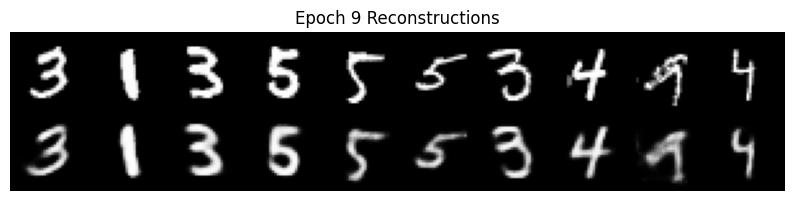

====> Test set loss: 101.5423


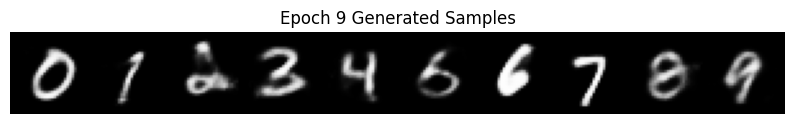

Epoch 10: 100%|██████████| 469/469 [00:04<00:00, 99.97it/s, Loss=103.1299] 


====> Epoch: 10 Average loss: 101.2840


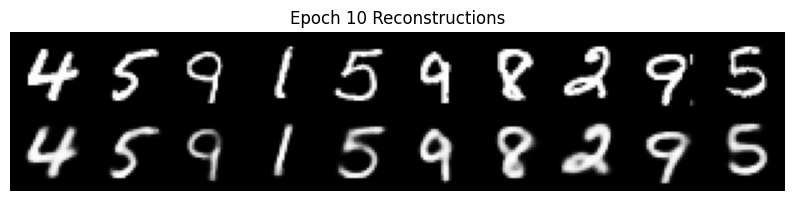

====> Test set loss: 100.7680


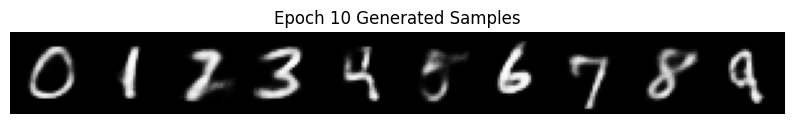

Epoch 11: 100%|██████████| 469/469 [00:04<00:00, 101.28it/s, Loss=97.6780] 


====> Epoch: 11 Average loss: 100.6975


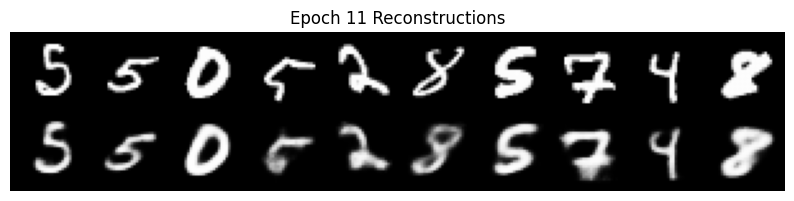

====> Test set loss: 100.1320


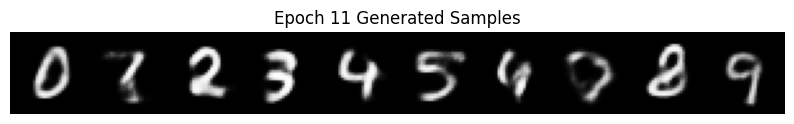

Epoch 12: 100%|██████████| 469/469 [00:05<00:00, 92.17it/s, Loss=99.3754]  


====> Epoch: 12 Average loss: 100.1079


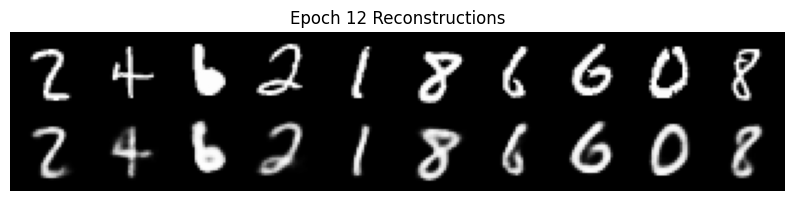

====> Test set loss: 99.7613


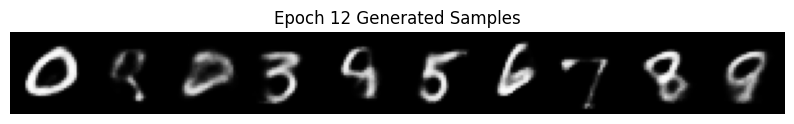

Epoch 13: 100%|██████████| 469/469 [00:05<00:00, 90.71it/s, Loss=98.4431]  


====> Epoch: 13 Average loss: 99.5728


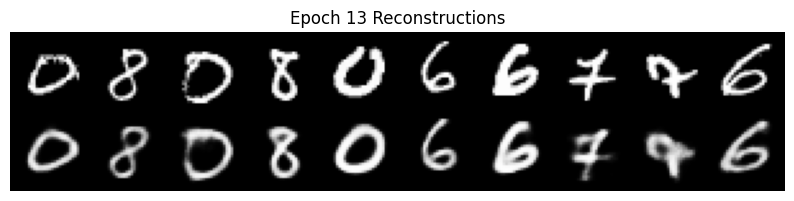

====> Test set loss: 99.3754


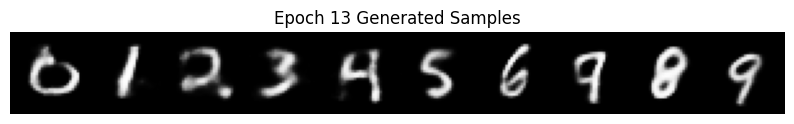

Epoch 14: 100%|██████████| 469/469 [00:05<00:00, 89.31it/s, Loss=99.4975]  


====> Epoch: 14 Average loss: 99.1440


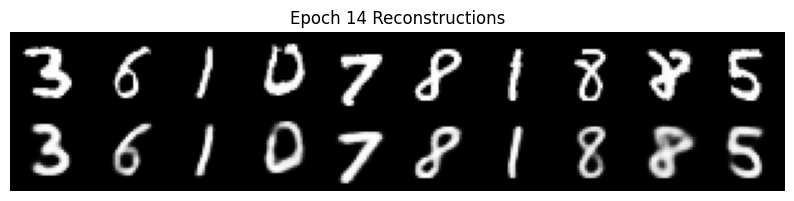

====> Test set loss: 99.1760


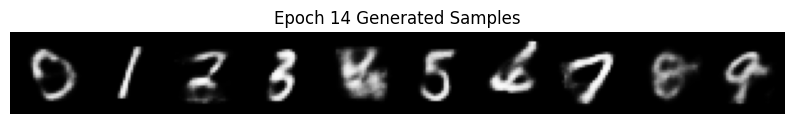

Epoch 15: 100%|██████████| 469/469 [00:05<00:00, 90.77it/s, Loss=100.8227] 


====> Epoch: 15 Average loss: 98.8119


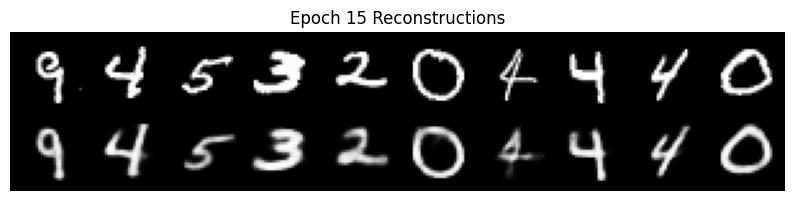

====> Test set loss: 99.0284


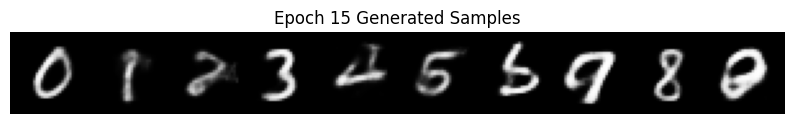

Epoch 16: 100%|██████████| 469/469 [00:04<00:00, 98.35it/s, Loss=98.6023]  


====> Epoch: 16 Average loss: 98.4696


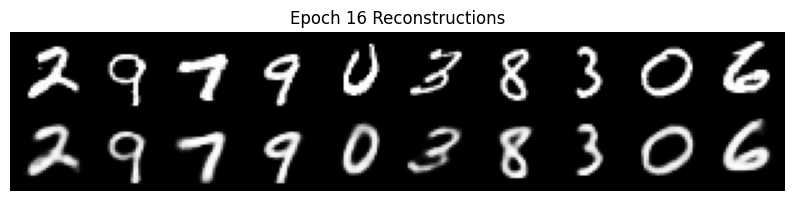

====> Test set loss: 98.6593


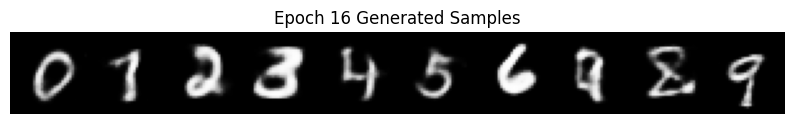

Epoch 17: 100%|██████████| 469/469 [00:05<00:00, 93.62it/s, Loss=99.8273]  


====> Epoch: 17 Average loss: 98.1443


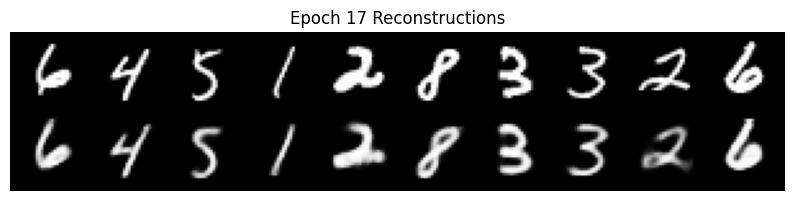

====> Test set loss: 98.5818


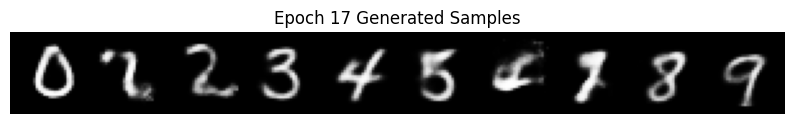

Epoch 18: 100%|██████████| 469/469 [00:05<00:00, 90.82it/s, Loss=98.1066]  


====> Epoch: 18 Average loss: 97.9051


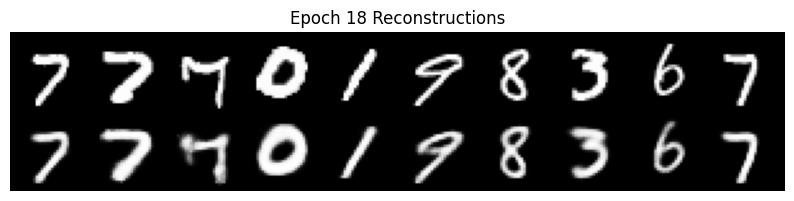

====> Test set loss: 98.0454


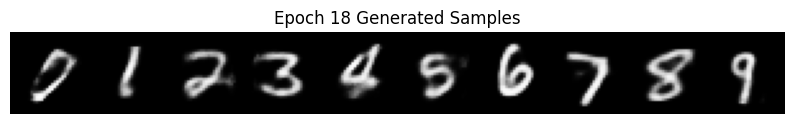

Epoch 19: 100%|██████████| 469/469 [00:05<00:00, 91.08it/s, Loss=97.3257]  


====> Epoch: 19 Average loss: 97.6285


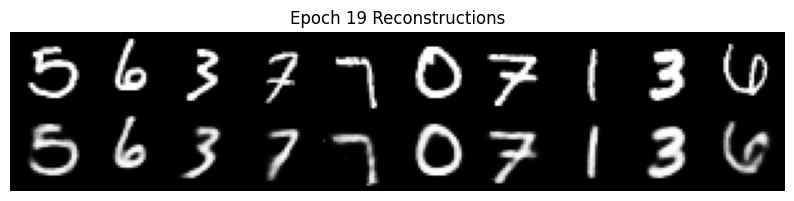

====> Test set loss: 97.9098


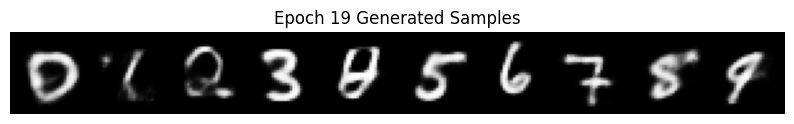

Epoch 20: 100%|██████████| 469/469 [00:04<00:00, 99.97it/s, Loss=98.1773]  


====> Epoch: 20 Average loss: 97.3836


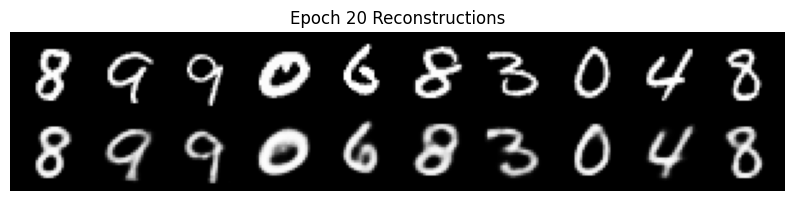

====> Test set loss: 97.5421


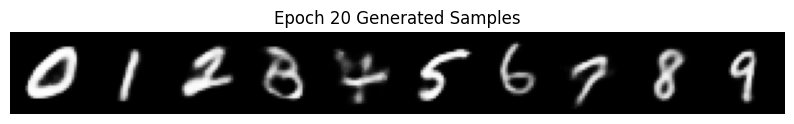

Training completed!


In [60]:
# Train the Model
history = {'train_loss': [], 'test_loss': []}

print("Starting training...")
for epoch in range(1, epochs + 1):
    train_loss = train(epoch, history)
    test_loss = test(epoch, history)
    
    # Step scheduler
    scheduler.step(test_loss)
    
    # Save generated samples
    save_samples(epoch)
    
    # Save model checkpoint
    if epoch % 5 == 0:
        torch.save(model.state_dict(), f'results/model_epoch_{epoch}.pth')

print("Training completed!")

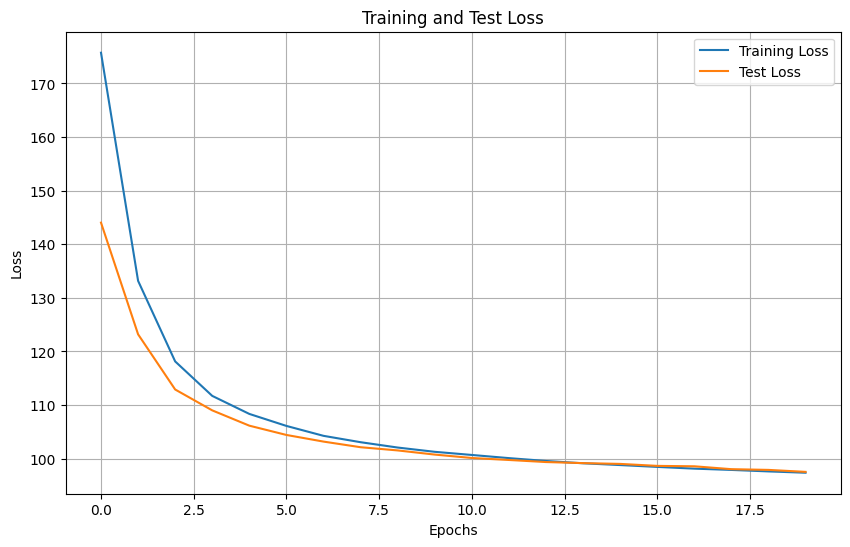

In [61]:
# Plot Training and Test Loss
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('results/loss_curve.png')
plt.show()

In [62]:
# Create Interpolation Animation
print("Creating latent space interpolation...")
latent_vectors = []

Creating latent space interpolation...


In [63]:
# Generate latent space trajectory
for i in np.linspace(0, 2*np.pi, 60):
    # Create circular trajectory in latent space
    z = torch.randn(1, latent_size).to(device)
    z[0, 0] = np.sin(i)
    z[0, 1] = np.cos(i)
    
    # Specify digit class (e.g., digit 8)
    c = torch.zeros(1, num_classes).to(device)
    c[0, 8] = 1.0
    
    # Generate image
    with torch.no_grad():
        sample = model.decode(z, c).cpu().view(1, 1, 28, 28)
    
    # Save to list
    latent_vectors.append(sample)

In [64]:
# Create grid image for each latent vector
images = []
for img_tensor in latent_vectors:
    img = make_grid(img_tensor, nrow=1, padding=0).permute(1, 2, 0).numpy()
    images.append((img * 255).astype(np.uint8))

In [65]:
# Save as GIF
imageio.mimsave('results/latent_space_interpolation.gif', images, duration=0.1)
print("Interpolation animation saved as latent_space_interpolation.gif")

# Show the animation
from IPython.display import Image
Image(filename="results/latent_space_interpolation.gif")

Interpolation animation saved as latent_space_interpolation.gif


In [71]:
import os
import imageio
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import glob

In [72]:
def create_training_gif(input_dir, output_gif, duration=0.5):
    """
    将训练过程中的样本图像序列转化为动态GIF
    
    参数:
    input_dir (str): 包含训练样本图像的目录路径
    output_gif (str): 输出的GIF文件名
    duration (float): 每帧显示时间（秒）
    """
    # 获取按epoch排序的所有图像文件
    image_paths = sorted(glob.glob(os.path.join(input_dir, 'sample_*.png')))
    
    # 如果没有找到图像
    if not image_paths:
        print(f"在目录 {input_dir} 中未找到sample_*.png文件")
        return
    
    print(f"找到 {len(image_paths)} 张样本图像，正在创建GIF...")
    
    # 读取所有图像
    images = []
    for path in image_paths:
        try:
            # 从文件名中提取epoch信息
            filename = os.path.basename(path)
            epoch_num = int(filename.split('_')[1].split('.')[0])
            
            # 读取图像并在左上角添加epoch标注
            img = Image.open(path)
            img = np.array(img)
            
            # 创建可绘制的图像对象
            fig, ax = plt.subplots(figsize=(10, 4))
            ax.imshow(img)
            ax.axis('off')
            
            # 添加epoch标注
            plt.text(5, 15, f'Epoch: {epoch_num}', color='white', 
                     fontsize=12, weight='bold', 
                     bbox=dict(facecolor='black', alpha=0.7, pad=3))
            
            plt.tight_layout()
            
            # 将图像转换为PIL可处理的格式
            fig.canvas.draw()
            img_array = np.array(fig.canvas.renderer.buffer_rgba())
            
            images.append(img_array)
            plt.close(fig)
            
        except Exception as e:
            print(f"处理 {path} 时出错: {e}")
    
    if not images:
        print("没有有效的图像可用于创建GIF")
        return
    
    # 保存为GIF
    try:
        imageio.mimsave(output_gif, images, duration=duration)
        print(f"成功创建训练过程GIF: {output_gif}")
        
        # 添加最后一帧延长显示时间
        with imageio.get_writer(output_gif, mode='I', duration=duration) as writer:
            for img in images[:-1]:
                writer.append_data(img)
            
            # 最后一帧显示更长时间
            for _ in range(5):
                writer.append_data(images[-1])
        
    except Exception as e:
        print(f"创建GIF时出错: {e}")

# 可视化生成的GIF
def display_gif(gif_path):
    """在Jupyter Notebook中显示GIF"""
    from IPython.display import Image
    return Image(filename=gif_path)

In [73]:
# 设置输入和输出路径
sample_dir = "./results/samples"  # 包含训练样本的目录
output_gif = "results/training_progress.gif"  # 输出的GIF文件路径

# 创建GIF（每帧0.5秒）
create_training_gif(sample_dir, output_gif, duration=1)

找到 40 张样本图像，正在创建GIF...
处理 ./results/samples\sample_grid_01.png 时出错: invalid literal for int() with base 10: 'grid'
处理 ./results/samples\sample_grid_02.png 时出错: invalid literal for int() with base 10: 'grid'
处理 ./results/samples\sample_grid_03.png 时出错: invalid literal for int() with base 10: 'grid'
处理 ./results/samples\sample_grid_04.png 时出错: invalid literal for int() with base 10: 'grid'
处理 ./results/samples\sample_grid_05.png 时出错: invalid literal for int() with base 10: 'grid'
处理 ./results/samples\sample_grid_06.png 时出错: invalid literal for int() with base 10: 'grid'
处理 ./results/samples\sample_grid_07.png 时出错: invalid literal for int() with base 10: 'grid'
处理 ./results/samples\sample_grid_08.png 时出错: invalid literal for int() with base 10: 'grid'
处理 ./results/samples\sample_grid_09.png 时出错: invalid literal for int() with base 10: 'grid'
处理 ./results/samples\sample_grid_10.png 时出错: invalid literal for int() with base 10: 'grid'
处理 ./results/samples\sample_grid_11.png 时出错: invalid lite